In [1]:
# Third Party libraries
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

from sklearn.linear_model import LinearRegression

In [2]:
# Import Data_cleaning module
from modules.data_clean import DataCleaner

# Load DF
df = pd.read_csv('../../data/raw/Fire_Incidents_Data.csv', low_memory=False)

In [3]:
# Feature Engineering before removing columns

df['Fire_Under_Control_Time'] = pd.to_datetime(df['Fire_Under_Control_Time'])
df['TFS_Alarm_Time'] = pd.to_datetime(df['TFS_Alarm_Time'])
df['TFS_Arrival_Time'] = pd.to_datetime(df['TFS_Arrival_Time'])

df['Control_Time'] = (df['Fire_Under_Control_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()
df['Response_Time'] = (df['TFS_Arrival_Time'] - df['TFS_Alarm_Time']).dt.total_seconds()

In [4]:
# Cleanse Dataframe
df = DataCleaner.cleanse_dataframe(df)

### Defining all features
- Numerical Columns
- Categorial Columns
    - Ordinal Columns
    - Onehot Columns

In [5]:
NUMERICAL_COLS = [
    "Civilian_Casualties",
    "Count_of_Persons_Rescued",
    "Estimated_Dollar_Loss",
    "Estimated_Number_Of_Persons_Displaced",
    "Number_of_responding_apparatus",
    "Number_of_responding_personnel",
    "TFS_Firefighter_Casualties",
    "Control_Time", 
    "Response_Time"
]

CATEGORICAL_COLS = ['Area_of_Origin', 'Building_Status', 'Business_Impact', 'Extent_Of_Fire', 'Final_Incident_Type', 
                'Fire_Alarm_System_Impact_on_Evacuation', 'Fire_Alarm_System_Operation', 'Fire_Alarm_System_Presence', 
                'Ignition_Source', 'Initial_CAD_Event_Type', 'Material_First_Ignited', 'Method_Of_Fire_Control', 
                'Possible_Cause', 'Property_Use', 'Smoke_Alarm_at_Fire_Origin', 'Smoke_Alarm_at_Fire_Origin_Alarm_Failure', 
                'Smoke_Alarm_at_Fire_Origin_Alarm_Type', 'Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation', 
                'Smoke_Spread', 'Sprinkler_System_Operation', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival', 'Incident_Ward']

# ['Business_Impact', 'Extent_Of_Fire', 'Sprinkler_System_Presence', 'Status_of_Fire_On_Arrival']
ORDINAL_COLS = CATEGORICAL_COLS[2:4] + CATEGORICAL_COLS[20:22]

# Everything else.
ONEHOT_COLS = list(set(CATEGORICAL_COLS) - set(ORDINAL_COLS))

### Imputation

#### Categorical Imputation

Will use SimpleImputer, as it can work with strings.

In [6]:
# Specify pd.NA as the missing value indicator for SimpleImputer
imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)

# Apply the imputer to the categorical columns
df[CATEGORICAL_COLS] = imputer.fit_transform(df[CATEGORICAL_COLS])

#### Numerical imputation.

This uses KNN for numerical columns missing data.

In [7]:
import numpy as np

# Replace pd.NA with np.nan
# KNNImputer does not directly support pd.NA
df = df.replace(pd.NA, np.nan)

imputer = KNNImputer()

# Apply the imputer to the categorical columns
df[NUMERICAL_COLS] = imputer.fit_transform(df[NUMERICAL_COLS])

### Categorical Encoding

Encoding all categorical columns as ordinal.

This yields bad results.

In [8]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import numpy as np

# Specify ordinal encoder
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)

# Apply the encoder to specified columns
df[CATEGORICAL_COLS] = ordinal_encoder.fit_transform(df[CATEGORICAL_COLS])
df

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Ward,Initial_CAD_Event_Type,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,Control_Time,Response_Time
0,60.0,0.0,5.0,0.0,0.0,15000.0,0.8,0.0,0.0,5.0,0.0,0.0,83.0,1.0,126.0,25.0,0.0,1.0,4.0,22.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,5.0,0.0,671.0,342.0
1,56.0,0.0,5.0,0.0,0.0,50.0,0.0,0.0,0.0,5.0,0.0,0.0,83.0,18.0,62.0,51.0,0.0,1.0,4.0,2.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,1.0,0.0,461.0,288.0
3,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,2.0,3.0,83.0,5.0,60.0,52.0,0.0,6.0,22.0,22.0,138.0,8.0,9.0,5.0,5.0,9.0,5.0,3.0,2.0,0.0,381.0,268.0
5,60.0,0.0,5.0,0.0,0.0,1500.0,0.0,0.0,0.0,5.0,0.0,0.0,83.0,25.0,126.0,25.0,0.0,7.0,25.0,22.0,281.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,3.0,0.0,521.0,238.0
6,6.0,0.0,0.0,0.0,0.0,2000.0,0.0,3.0,0.0,5.0,2.0,2.0,47.0,19.0,72.0,5.0,0.0,6.0,22.0,6.0,71.0,0.0,9.0,4.0,4.0,1.0,5.0,2.0,1.0,0.0,665.0,352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29419,60.0,0.0,5.0,0.0,0.0,50000.0,0.6,0.0,0.0,5.0,0.0,0.0,69.0,2.0,115.0,59.0,0.0,5.0,18.0,26.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,2.0,0.0,697.0,375.0
29420,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,83.0,13.0,26.0,59.0,0.0,5.0,17.0,28.0,81.0,3.0,9.0,3.0,2.0,2.0,2.0,0.0,1.0,0.0,1084.0,358.0
29421,60.0,0.0,5.0,0.2,0.0,5000.0,0.0,0.0,0.0,5.0,0.0,0.0,68.0,20.0,114.0,59.0,0.0,1.0,4.0,26.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,2.0,0.0,358.0,243.0
29422,25.0,0.0,5.0,0.0,0.0,2000.0,0.0,3.0,0.0,2.0,0.0,0.0,83.0,13.0,26.0,61.0,0.0,8.0,26.0,27.0,81.0,3.0,9.0,3.0,5.0,3.0,1.0,0.0,1.0,0.0,625.0,228.0


Encoding onehot columns - Work in progress/Not working.

In [9]:


# onehot_encoder = OneHotEncoder(handle_unknown="ignore")
# # Apply the imputer to the categorical columns
# df_encoded= onehot_encoder.fit_transform(df[ONEHOT_COLS])

# df_encoded

# from sklearn.preprocessing import OneHotEncoder
# from sklearn.linear_model import LinearRegression

# # X is a numpy array with your features
# # y is the label array
# enc = OneHotEncoder(sparse=False)
# X_transform = enc.fit_transform(X)

# # apply your linear regression as you want
# model = LinearRegression()
# model.fit(X_transform, y)

# print("Mean squared error: %.2f" % np.mean((model.predict(X_transform) - y) ** 2))

### Standard scaler on numerical Data

Will scale all numerical columns.

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the DataFrame
df[NUMERICAL_COLS] = scaler.fit_transform(df[NUMERICAL_COLS])

### Log transform response variable.

In [11]:
# Log transform the Estimated_Dollar_Loss column
df['Estimated_Dollar_Loss'] = np.log(df['Estimated_Dollar_Loss'] + 1)  # Adding 1 to avoid log(0) issue

In [12]:
df

,Area_of_Origin,Building_Status,Business_Impact,Civilian_Casualties,Count_of_Persons_Rescued,Estimated_Dollar_Loss,Estimated_Number_Of_Persons_Displaced,Extent_Of_Fire,Final_Incident_Type,Fire_Alarm_System_Impact_on_Evacuation,Fire_Alarm_System_Operation,Fire_Alarm_System_Presence,Ignition_Source,Incident_Ward,Initial_CAD_Event_Type,Material_First_Ignited,Method_Of_Fire_Control,Number_of_responding_apparatus,Number_of_responding_personnel,Possible_Cause,Property_Use,Smoke_Alarm_at_Fire_Origin,Smoke_Alarm_at_Fire_Origin_Alarm_Failure,Smoke_Alarm_at_Fire_Origin_Alarm_Type,Smoke_Alarm_Impact_on_Persons_Evacuating_Impact_on_Evacuation,Smoke_Spread,Sprinkler_System_Operation,Sprinkler_System_Presence,Status_of_Fire_On_Arrival,TFS_Firefighter_Casualties,Control_Time,Response_Time
0,60.0,0.0,5.0,-0.227276,-0.052416,-0.154712,-0.133982,0.0,0.0,5.0,0.0,0.0,83.0,1.0,126.0,25.0,0.0,-0.888237,-0.922813,22.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,5.0,-0.09813,-0.192287,0.073676
1,56.0,0.0,5.0,-0.227276,-0.052416,-0.382436,-0.142111,0.0,0.0,5.0,0.0,0.0,83.0,18.0,62.0,51.0,0.0,-0.888237,-0.922813,2.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,1.0,-0.09813,-0.285803,-0.095894
3,56.0,0.0,0.0,-0.227276,-0.052416,-0.383292,-0.142111,0.0,0.0,6.0,2.0,3.0,83.0,5.0,60.0,52.0,0.0,-0.214325,-0.141605,22.0,138.0,8.0,9.0,5.0,5.0,9.0,5.0,3.0,2.0,-0.09813,-0.321428,-0.158698
5,60.0,0.0,5.0,-0.227276,-0.052416,-0.357935,-0.142111,0.0,0.0,5.0,0.0,0.0,83.0,25.0,126.0,25.0,0.0,-0.079543,-0.011403,22.0,281.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,3.0,-0.09813,-0.259084,-0.252903
6,6.0,0.0,0.0,-0.227276,-0.052416,-0.349623,-0.142111,3.0,0.0,5.0,2.0,2.0,47.0,19.0,72.0,5.0,0.0,-0.214325,-0.141605,6.0,71.0,0.0,9.0,4.0,4.0,1.0,5.0,2.0,1.0,-0.09813,-0.194959,0.105078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29419,60.0,0.0,5.0,-0.227276,-0.052416,0.235156,-0.136014,0.0,0.0,5.0,0.0,0.0,69.0,2.0,115.0,59.0,0.0,-0.349107,-0.315207,26.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,2.0,-0.09813,-0.180709,0.177303
29420,23.0,0.0,0.0,-0.227276,-0.052416,-0.383292,-0.142111,0.0,0.0,2.0,0.0,0.0,83.0,13.0,26.0,59.0,0.0,-0.349107,-0.358607,28.0,81.0,3.0,9.0,3.0,2.0,2.0,2.0,0.0,1.0,-0.09813,-0.008373,0.123919
29421,60.0,0.0,5.0,0.306896,-0.052416,-0.301155,-0.142111,0.0,0.0,5.0,0.0,0.0,68.0,20.0,114.0,59.0,0.0,-0.888237,-0.922813,26.0,313.0,2.0,9.0,4.0,0.0,1.0,5.0,2.0,2.0,-0.09813,-0.331670,-0.237202
29422,25.0,0.0,5.0,-0.227276,-0.052416,-0.349623,-0.142111,3.0,0.0,2.0,0.0,0.0,83.0,13.0,26.0,61.0,0.0,0.055240,0.031997,27.0,81.0,3.0,9.0,3.0,5.0,3.0,1.0,0.0,1.0,-0.09813,-0.212772,-0.284305


### Train test split

In [13]:
from sklearn.model_selection import train_test_split

# List all columns in the DataFrame
all_columns = df.columns.tolist()

# Use every other column in the df except for the response variable
features = [col for col in all_columns if col != 'Estimated_Dollar_Loss']

# Separate features from response variable
X, y = df[features], df['Estimated_Dollar_Loss']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=12)

## Modelling.

### Helper Functions

In [14]:
# Function: Print Results of a Model (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT).
def print_results(r2, mae, mse, coefficients, intercept):
    print(f"R-squared score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"Coefficients: {coefficients}")
    print(f"Intercept: {intercept}")

# Function: Return Results (R2, MEAN ABSOLUTE ERROR, MEAN SQUARED ERROR, COEF and INTERCEPT)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def get_results(model, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    coefficients = model.coef_
    intercept = model.intercept_
    return (r2, mae, mse, coefficients, intercept)

# Function: Plot Scatter plot for regression model. (y_pred = lr.predict(X_test), R2 Score)
import matplotlib.pyplot as plt
import seaborn as sns
def plotRegression(y_pred, r2):
    # Scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.8)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red')  # Identity line
    plt.title('Actual vs. Predicted (Regression)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

    # Annotate plot with R-squared value
    plt.text(y_test.min(), y_test.max(), f'$R^2 = {r2:.2f}$', fontsize=12, verticalalignment='top')

    plt.show()

### Linear Regression

---------MLR----------
R-squared score: 0.4982
Mean Absolute Error: 0.18885643817311204
Mean Squared Error: 0.09125681945471095
Coefficients: [-5.97387944e-04 -4.76036481e-03  9.07569522e-03  2.13247593e-02
  3.91638493e-03  2.94675718e-02  3.52437002e-02  7.72446744e-02
  5.23512053e-03  1.32074331e-03  1.46605079e-02 -1.71963677e-05
 -9.21335425e-05  1.64245079e-03  2.75190639e-04 -2.02707209e-02
 -1.37770525e-01  3.24008677e-01  1.47912613e-03  1.75685293e-04
  4.48421002e-03  1.08015980e-02  1.92862390e-03 -2.56671007e-03
  3.70625787e-03  2.23807530e-03 -1.99052329e-02  3.14142878e-02
  2.09169251e-02  2.22971577e-02  1.21539180e-02]
Intercept: -0.5319058100459132


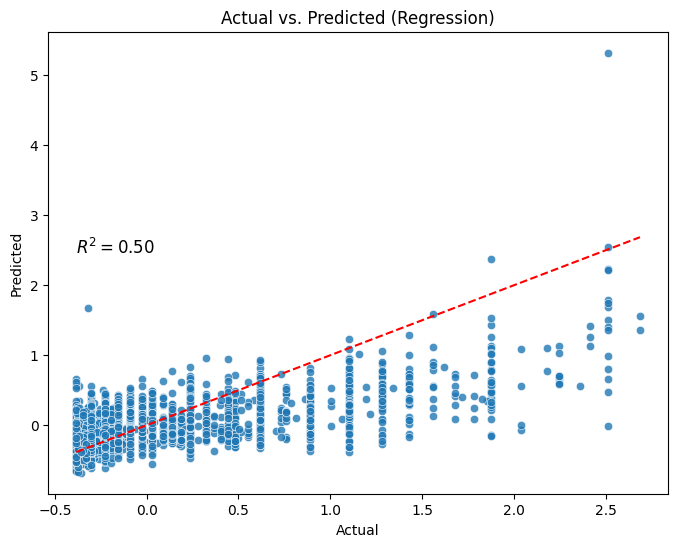

----------------------


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

lr = LinearRegression() # to do - settings hyperparameters 
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
residuals_lr = y_test - y_pred_lr

(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr) = get_results(lr, y_test, y_pred_lr)

# Results - Another option would be to use statsmodels to display a summary
print("---------MLR----------")
print_results(r2_lr, mae_lr, mse_lr, coefficients_lr, intercept_lr)
plotRegression(y_pred_lr, r2_lr)
print("----------------------")

### Lasso Regression

---------LASSO----------
R-squared score: 0.0050
Mean Absolute Error: 0.27546187522614746
Mean Squared Error: 0.18093335069258049
Coefficients: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.         -0.          0.          0.
  0.         -0.00015448  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.        ]
Intercept: -0.12569878120827602
------------------------
---------LASSO CV BEST----------
R-squared score: 0.4910
Mean Absolute Error: 0.18692375449033913
Mean Squared Error: 0.09255881465961942
Coefficients: [-4.66687344e-04 -0.00000000e+00  8.13848474e-03  8.87747386e-03
  0.00000000e+00  2.24109057e-02  3.60075954e-02  0.00000000e+00
  3.29636782e-03  0.00000000e+00  3.58048123e-03 -8.72578733e-06
 -4.01738490e-05  1.67636624e-03  3.47609863e-04 -1.20723677e-02
  1.55468729e-01  3.12588613e-02  1.86092526e-03

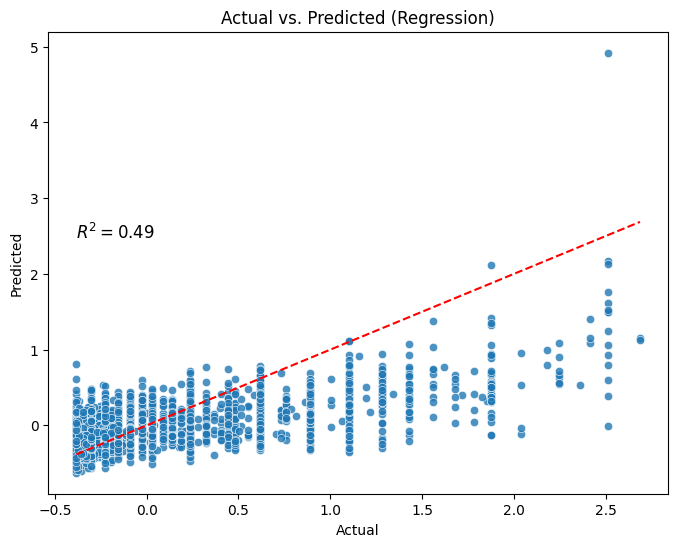

---------------------------


In [16]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Need to scale before using Lasso. I am not sure if we've already done in preprocessing
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.fit_transform(X_test)

# Lasso Model 1 = basic

lasso = Lasso(tol=0.05)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso) = get_results(lasso, y_test, y_pred_lasso)

print("---------LASSO----------")
print_results(r2_lasso, mae_lasso, mse_lasso, coefficients_lasso, intercept_lasso)
print("------------------------")

# Lasso Model 2 = Testing different parameters (CROSS-VALIDATOR: CV)

param_grid = {
	'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]	
}

lasso_cv = GridSearchCV(lasso, param_grid, cv=3, n_jobs=-1)
lasso_cv.fit(X_train, y_train)

# Get the Lasso with the best estimators
lasso_best = lasso_cv.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_test)
(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best) = get_results(lasso_best, y_test, y_pred_lasso_best)

print("---------LASSO CV BEST----------")
print_results(r2_lasso_best, mae_lasso_best, mse_lasso_best, coefficients_lasso_best, intercept_lasso_best)
plotRegression(y_pred_lasso_best, r2_lasso_best)
print("---------------------------")